In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in some data

Let's plot and read in some data

In [2]:
data = pd.read_csv('data/profile_data.csv')
data

,Station Label,Northing (m),Elevation (m),Time (h),obs (mGal)
0,Base,NaN,NaN,0.00,980081.07
1,0,0.0,1812.02,0.15,979724.81
2,1,50.0,1812.03,0.28,979724.96
3,2,100.0,1812.03,0.44,979725.13
4,3,150.0,1812.03,0.56,979725.28
5,4,200.0,1812.03,0.70,979725.44
6,5,250.0,1812.02,0.85,979725.62
7,6,300.0,1812.00,0.98,979725.79
8,7,350.0,1811.93,1.10,979725.97
9,Base,NaN,NaN,1.20,980081.94


First, let's get the indices of the base stations, and the indices of everywhere else.

In [3]:
base_inds = np.where(data['Station Label'] == "Base")[0]
station_inds = np.where(data['Station Label'] != "Base")[0]
base_inds

array([ 0,  9, 20, 32, 45])

Now let's plot the observed value at each station, according to its northing location

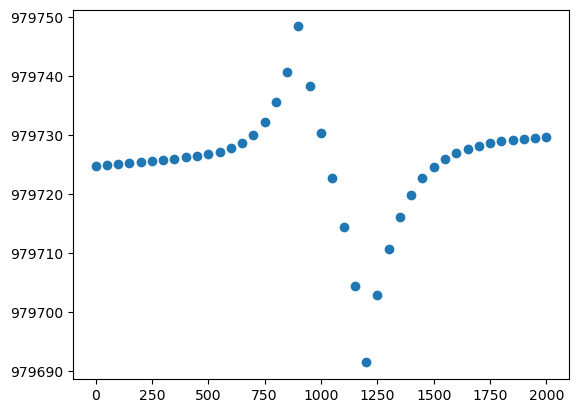

In [4]:
plt.scatter(data['Northing (m)'][station_inds], data['obs (mGal)'][station_inds])

# Drift-Correction

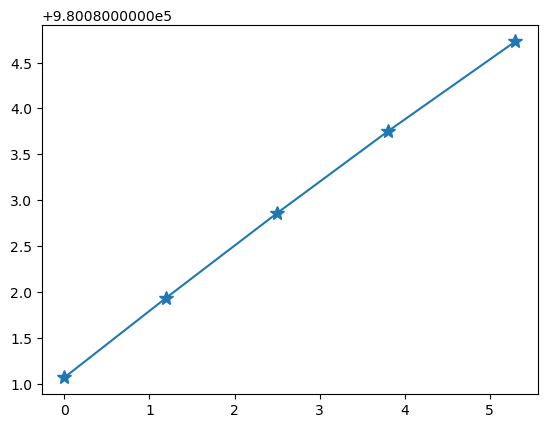

In [5]:
plt.plot(data['Time (h)'][base_inds], data['obs (mGal)'][base_inds], marker='*', markersize=10)

We can do some nice stuff with python here to make this easy!
So what do we want?
* Need a function that describes the base station as a function of time...
* Remove that variability from the observed data.

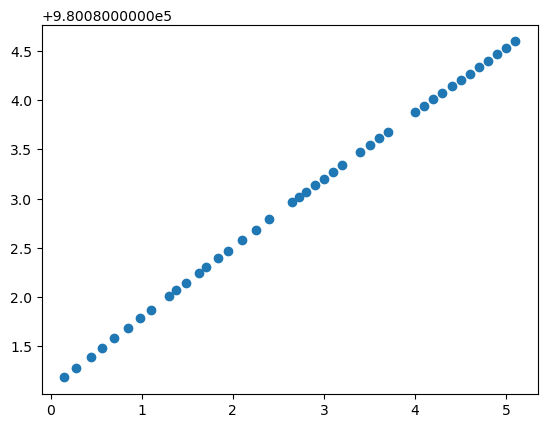

In [6]:
# part one sounds like an interpolation....
# Want to interpolate the values of the base station at times of the observations!
times = data['Time (h)']
obs = data['obs (mGal)']

g_drift = np.interp(times[station_inds], times[base_inds], obs[base_inds])

plt.scatter(times[station_inds], g_drift)

Text(0, 0.5, 'drift corrected (mGal)')

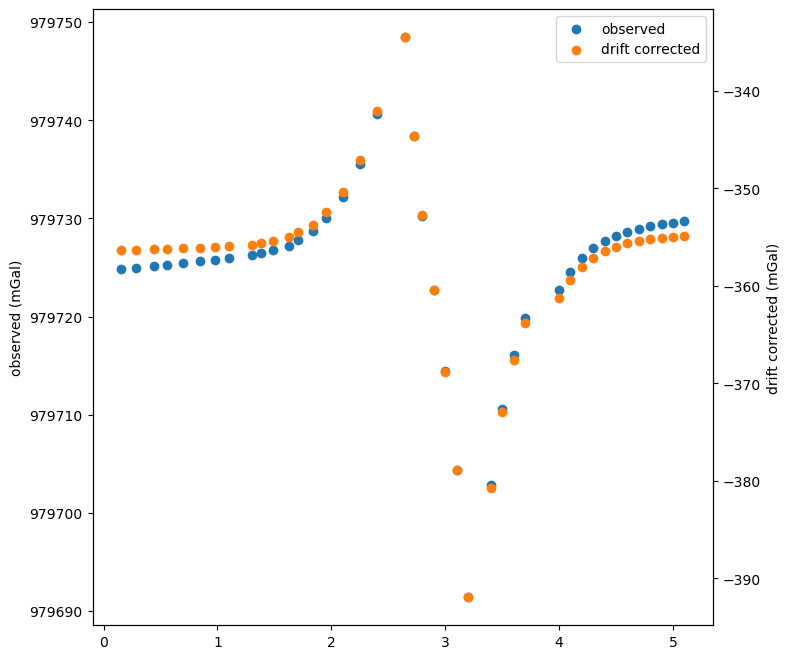

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

p1 = ax1.scatter(times[station_inds], obs[station_inds], color='C0', label='observed')
p2 = ax2.scatter(times[station_inds], obs[station_inds]-g_drift, color='C1', label='drift corrected')

ax1.legend(handles=[p1, p2])
ax1.set_ylabel('observed (mGal)')
ax2.set_ylabel('drift corrected (mGal)')

Now the other ones are pretty formulaic
# Free air

$$ \Delta g_{FA} = -0.3086 (mGal/m) * h $$

Text(0, 0.5, 'Elevations (m)')

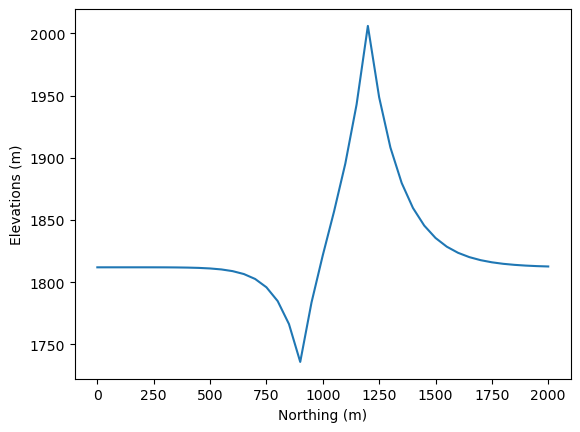

In [8]:
# Do the free air correction
profile = data['Northing (m)'][station_inds]
height = data['Elevation (m)'][station_inds]
plt.plot(profile, height)
plt.xlabel('Northing (m)')
plt.ylabel('Elevations (m)')

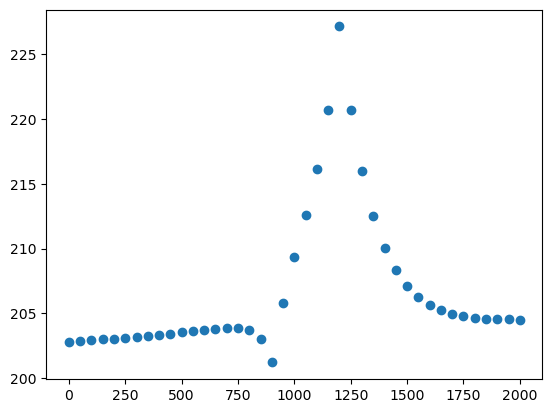

In [9]:
g_obs = data['obs (mGal)'][station_inds]

g_fa = -0.3086 * height


plt.scatter(profile, g_obs - g_drift - g_fa)

# Simple Bouguer correction

The simple bouguer correction removes an infinite slab with a thickness $h$ from the data.

$$\Delta g_{Bouguer} = 2 \pi \gamma \rho h$$

For $\rho = 2.67 g/cc$ this gives:

$$\Delta g_{booger} = 0.1119 (mGal/m) * h $$

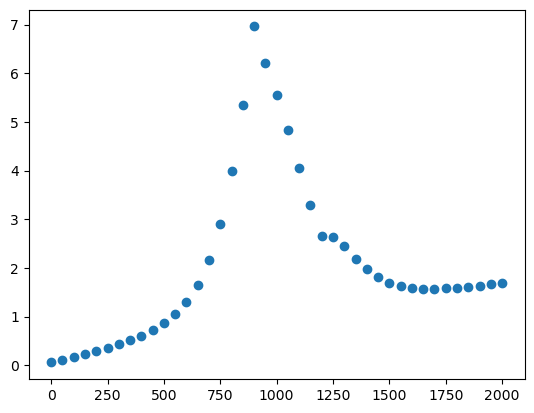

In [10]:
g_booger = 0.1119 * height # 2 pi gamma rho * h,  (rho=2.67)


plt.scatter(profile, g_obs - g_drift - g_fa - g_booger)

# Latitude correction

The full latitude correction is:

$$ \Delta g_{Lat} = g_e \left( \frac{1 + k \sin^2 \phi}{\sqrt{1-e^2 \sin^2 \phi}} - 1\right)$$

with $g_e = 978032.67714 mGal$, $k =  0.00193185138639$, and $e^2=0.00669437999013$ at latitude $\phi$


However for this data set, we do not know the latitude of each point, we are only given the latitude at the relative 0 North of the profile (45$\degrees$) and the distance north from each point, thus we will use the local approximation:

$$ \Delta g_{Lat} = 0.001626 (mGal/m) * \sin\phi\cos\phi * \Delta y$$

where $\Delta y$ is the difference in northing from the reference latitude point at $\phi$

this data has a reference point of 45$\degree

**note:** Remember to convert from degrees to radians for numpy!

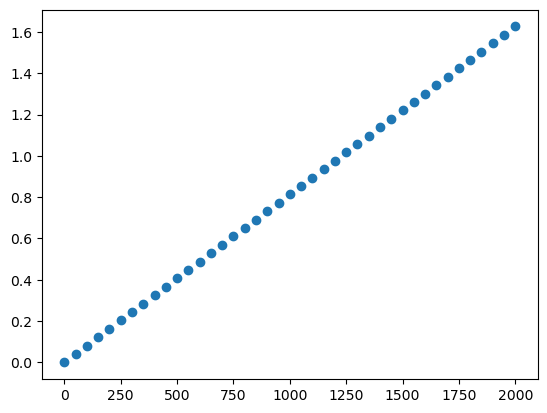

In [20]:
plt.scatter(profile, g_lat)

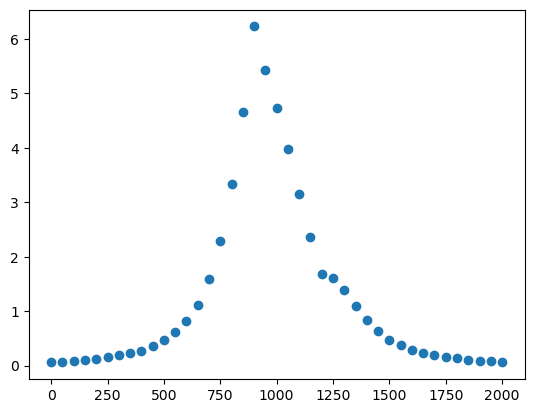

In [19]:
lat = np.pi/180 * 45

g_lat = 0.001626 * np.sin(lat) * np.cos(lat) * profile



plt.scatter(profile, g_obs - g_drift - g_fa - g_booger - g_lat)